Here I implement a LRP for a CNN that classifies the type of brain tumor. The LRP operates by propagating the prediction backward in the neural network and is a function of neuron activations and weights as explained in https://link.springer.com/chapter/10.1007/978-3-030-28954-6_10. The Brain Tumor Classification (MRI) dataset from Kaggle was used here.

Below cells show the results we aim to achieve in this notebook. 

Groundtruth for this image:  meningioma_tumor


/tmp/ipykernel_28/768859538.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


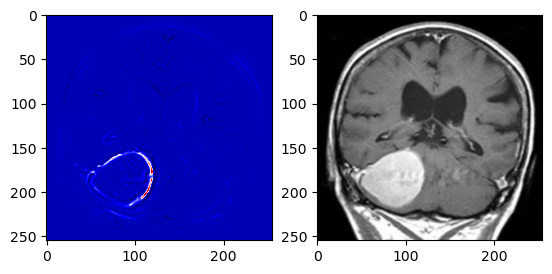

In [27]:
display_rel(1)

Groundtruth for this image:  no_tumor


/tmp/ipykernel_28/768859538.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


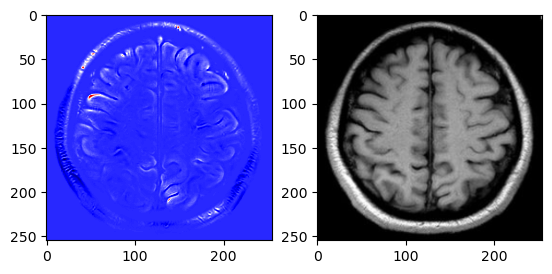

In [38]:
display_rel(7)

Groundtruth for this image:  pituitary_tumor


/tmp/ipykernel_28/768859538.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


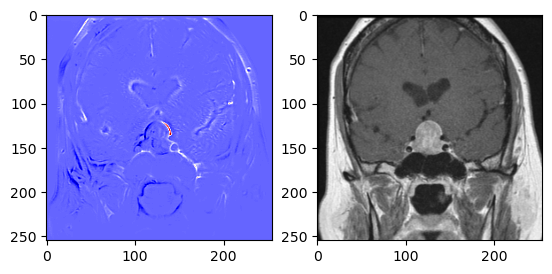

In [69]:
display_rel(13)

Following code was mainly inspired from https://github.com/deepfindr/xai-series with some minor changes

In [2]:
# %% Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd 

# Set GPU device
print(torch.cuda.is_available())
device = torch.device("cuda:0")

True


In [3]:
# %% Load data
TRAIN_ROOT = "/kaggle/input/brain-tumor-classification-mri/Training"
TEST_ROOT = "/kaggle/input/brain-tumor-classification-mri/Testing"
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT)
test_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT)

In [4]:
# %% Prepare data for pretrained model
train_dataset = torchvision.datasets.ImageFolder(
        root=TRAIN_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((255,255)),
                      transforms.ToTensor()
        ])
)

test_dataset = torchvision.datasets.ImageFolder(
        root=TEST_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((255,255)),
                      transforms.ToTensor()
        ])
)

#train_dataset[0][0].permute(1,2,0)

# %% Create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

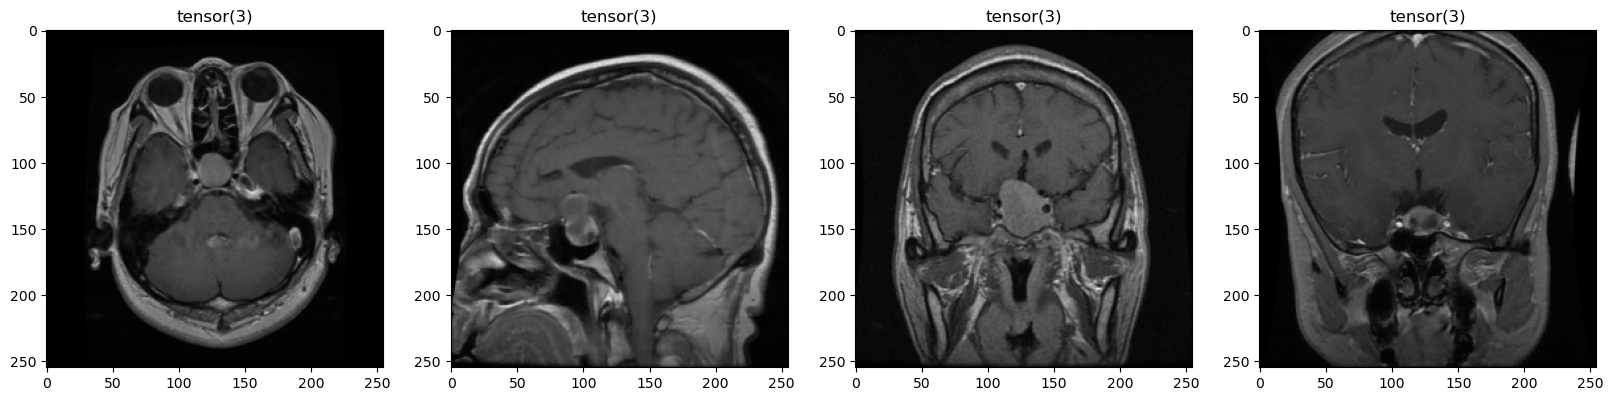

In [5]:
inputs_plot, labels = next(iter(train_loader))
#view images. tensor0=American flag and tensor1=Ukrainian
import torchvision.transforms as T
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(0,4):
    ds=inputs_plot[idx]
    img=T.ToPILImage()(ds)
    ax[idx].imshow(img)
    ax[idx].title.set_text(labels[idx])

In [6]:
# %% Building the model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True) 

        # Replace output layer according to our problem
        in_feats = self.vgg16.classifier[6].in_features 
        self.vgg16.classifier[6] = nn.Linear(in_feats, 4)

    def forward(self, x):
        x = self.vgg16(x)
        return x

model = CNNModel()
model.to(device)
model



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 226MB/s]  


CNNModel(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [7]:
# %% Train
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
epochs = 10

# Iterate x epochs over the train data
for epoch in range(epochs):  
    for i, batch in enumerate(train_loader, 0):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Labels are automatically one-hot-encoded
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        print(loss)

# %% Inspect predictions for first batch
import pandas as pd
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.numpy()
outputs = model(inputs).max(1).indices.detach().cpu().numpy()
comparison = pd.DataFrame()
print("Batch accuracy: ", (labels==outputs).sum()/len(labels))
comparison["labels"] = labels

comparison["outputs"] = outputs
comparison

# %% Layerwise relevance propagation for VGG16
# For other CNN architectures this code might become more complex
# Source: https://git.tu-berlin.de/gmontavon/lrp-tutorial
# http://iphome.hhi.de/samek/pdf/MonXAI19.pdf

def new_layer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    try: layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError: pass
    try: layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError: pass
    return layer

def dense_to_conv(layers):
    """ Converts a dense layer to a conv layer """
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer, nn.Linear):
            newlayer = None
            if i == 0:
                m, n = 512, layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))
            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers

def get_linear_layer_indices(model):
    offset = len(model.vgg16._modules['features']) + 1
    indices = []
    for i, layer in enumerate(model.vgg16._modules['classifier']): 
        if isinstance(layer, nn.Linear): 
            indices.append(i)
    indices = [offset + val for val in indices]
    return indices

def apply_lrp_on_vgg16(model, image):
    image = torch.unsqueeze(image, 0)
    # >>> Step 1: Extract layers
    layers = list(model.vgg16._modules['features']) \
                + [model.vgg16._modules['avgpool']] \
                + dense_to_conv(list(model.vgg16._modules['classifier']))
    linear_layer_indices = get_linear_layer_indices(model)
    # >>> Step 2: Propagate image through layers and store activations
    n_layers = len(layers)
    activations = [image] + [None] * n_layers # list of activations
    
    for layer in range(n_layers):
        if layer in linear_layer_indices:
            if layer == 32:
                activations[layer] = activations[layer].reshape((1, 512, 7, 7))
        activation = layers[layer].forward(activations[layer])
        if isinstance(layers[layer], torch.nn.modules.pooling.AdaptiveAvgPool2d):
            activation = torch.flatten(activation, start_dim=1)
        activations[layer+1] = activation

    # >>> Step 3: Replace last layer with one-hot-encoding
    output_activation = activations[-1].detach().cpu().numpy()
    max_activation = output_activation.max()
    one_hot_output = [val if val == max_activation else 0 
                        for val in output_activation[0]]

    activations[-1] = torch.FloatTensor([one_hot_output]).to(device)

    # >>> Step 4: Backpropagate relevance scores
    relevances = [None] * n_layers + [activations[-1]]
    # Iterate over the layers in reverse order
    for layer in range(0, n_layers)[::-1]:
        current = layers[layer]
        # Treat max pooling layers as avg pooling
        if isinstance(current, torch.nn.MaxPool2d):
            layers[layer] = torch.nn.AvgPool2d(2)
            current = layers[layer]
        if isinstance(current, torch.nn.Conv2d) or \
           isinstance(current, torch.nn.AvgPool2d) or\
           isinstance(current, torch.nn.Linear):
            activations[layer] = activations[layer].data.requires_grad_(True)
            
            # Apply variants of LRP depending on the depth
            # see: https://link.springer.com/chapter/10.1007%2F978-3-030-28954-6_10
            # Lower layers, LRP-gamma >> Favor positive contributions (activations)
            if layer <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
            # Middle layers, LRP-epsilon >> Remove some noise / Only most salient factors survive
            if 17 <= layer <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            # Upper Layers, LRP-0 >> Basic rule
            if layer >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9
            
            # Transform weights of layer and execute forward pass
            z = incr(new_layer(layers[layer],rho).forward(activations[layer]))
            # Element-wise division between relevance of the next layer and z
            s = (relevances[layer+1]/z).data                                     
            # Calculate the gradient and multiply it by the activation
            (z * s).sum().backward(); 
            c = activations[layer].grad       
            # Assign new relevance values           
            relevances[layer] = (activations[layer]*c).data                          
        else:
            relevances[layer] = relevances[layer+1]

    # >>> Potential Step 5: Apply different propagation rule for pixels
    return relevances[0]

tensor(1.5028, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4717, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4257, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3339, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3674, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2435, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3480, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2490, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3238, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2510, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2882, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1958, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2558, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1645, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1670, device='cuda:0', grad_fn=

In [8]:
# Calculate relevances for first image in this test batch
def display_rel(image_id):
    image_relevances = apply_lrp_on_vgg16(model, inputs[image_id])
    image_relevances = image_relevances.permute(0,2,3,1).detach().cpu().numpy()[0]
    image_relevances = np.interp(image_relevances, (image_relevances.min(),
                                                    image_relevances.max()), 
                                                    (0, 1))
    # Show relevances
    pred_label = list(test_dataset.class_to_idx.keys())[
                 list(test_dataset.class_to_idx.values())
                .index(labels[image_id])]
    if outputs[image_id] == labels[image_id]:
        print("Groundtruth for this image: ", pred_label)

        # Plot images next to each other
        plt.axis('off')
        plt.subplot(1,2,1)
        plt.imshow(image_relevances[:,:,0], cmap="seismic")
        plt.subplot(1,2,2)
        plt.imshow(inputs[image_id].permute(1,2,0).detach().cpu().numpy())
        plt.show()
    else:
        print("This image is not classified correctly.")

# %%
#Relevence highlights features in image responsible for prediction

/tmp/ipykernel_28/63858872.py:102: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  activations[-1] = torch.FloatTensor([one_hot_output]).to(device)
/tmp/ipykernel_28/768859538.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Groundtruth for this image:  meningioma_tumor


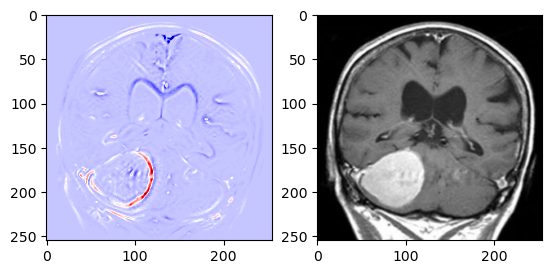

In [9]:
display_rel(1)

Groundtruth for this image:  no_tumor


/tmp/ipykernel_28/768859538.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


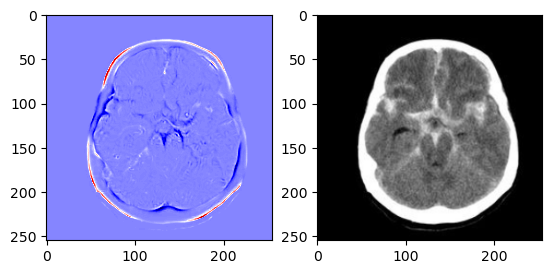

In [10]:
display_rel(3)

Groundtruth for this image:  meningioma_tumor


/tmp/ipykernel_28/768859538.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


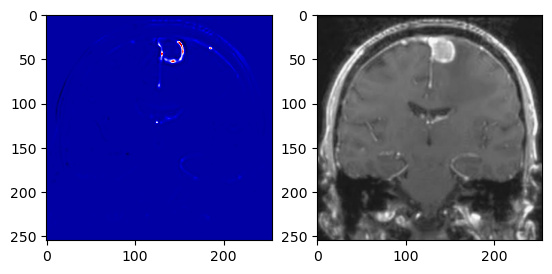

In [11]:
display_rel(5)

Groundtruth for this image:  pituitary_tumor


/tmp/ipykernel_28/768859538.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


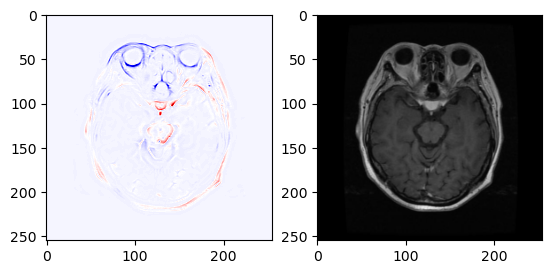

In [12]:
display_rel(10)

Groundtruth for this image:  meningioma_tumor


/tmp/ipykernel_28/768859538.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


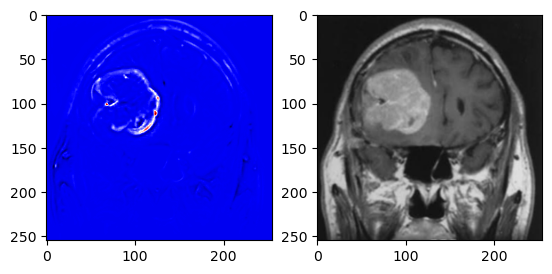

In [13]:
display_rel(11)

Groundtruth for this image:  pituitary_tumor


/tmp/ipykernel_28/768859538.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


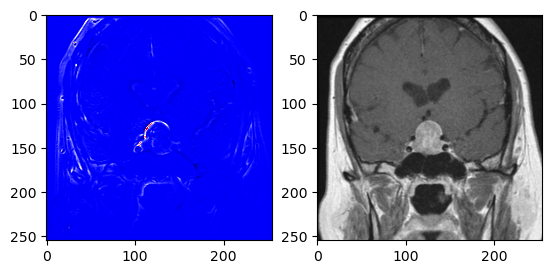

In [14]:
display_rel(13)

Groundtruth for this image:  meningioma_tumor


/tmp/ipykernel_28/768859538.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


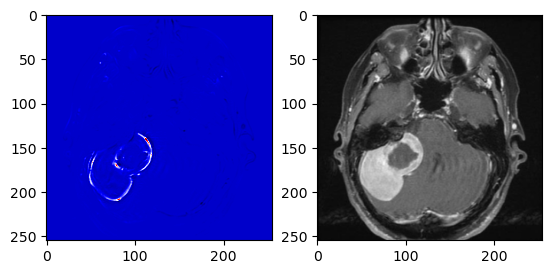

In [47]:
display_rel(14)

Groundtruth for this image:  no_tumor


/tmp/ipykernel_28/768859538.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


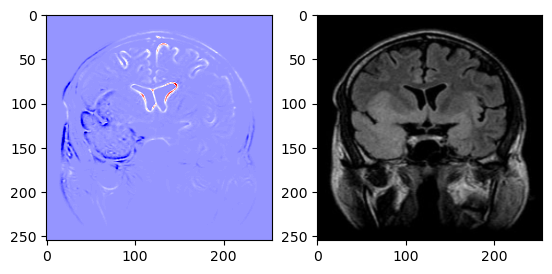

In [15]:
display_rel(15)

Groundtruth for this image:  meningioma_tumor


/tmp/ipykernel_28/768859538.py:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


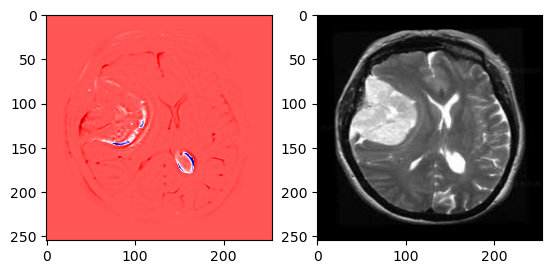

In [16]:
display_rel(24)